# Convolutional Network


### Import packages


In [1]:
import copy
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from utils import plot_loss_epoch

### Load data


In [2]:
bidding_area = 3

data = pd.read_csv(f"data/NO{bidding_area}.csv")

data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")

data.head()

,temperature,consumption
timestamp,,
2017-05-01 00:00:00+00:00,5.5,2674.838
2017-05-01 01:00:00+00:00,4.0,2678.188
2017-05-01 02:00:00+00:00,3.7,2678.341
2017-05-01 03:00:00+00:00,3.2,2684.172
2017-05-01 04:00:00+00:00,2.7,2733.345


### Split data


In [3]:
df_train, df_test = train_test_split(data, test_size=0.1, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=0.1, shuffle=False)

### Normalization


In [4]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

df_train.head()

,temperature,consumption
timestamp,,
2017-05-01 00:00:00+00:00,-0.132928,-0.840752
2017-05-01 01:00:00+00:00,-0.326872,-0.833733
2017-05-01 02:00:00+00:00,-0.365661,-0.833413
2017-05-01 03:00:00+00:00,-0.430308,-0.821196
2017-05-01 04:00:00+00:00,-0.494956,-0.718170


### Define model


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


class Convolutional(nn.Module):
    def __init__(self, tw: int):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(
                in_channels=tw, out_channels=32, kernel_size=3, stride=1, padding=1
            ),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(32),
            nn.Conv1d(
                in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
            ),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Conv1d(
                in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
            ),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2, 2),
        )
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=128, out_features=32),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=32, out_features=1),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return self.linear_stack(x.view(x.shape[0], -1))


model = Convolutional(tw=100).to(device)
model

Convolutional(
  (conv_stack): Sequential(
    (0): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

### Loss function and optimizer


In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Create dataset for sequences of datapoints as features


In [7]:
class SequenceDataset(Dataset):
    def __init__(self, df, time_window: int, padding: int):
        self.df = df
        self.time_window = time_window
        self.padding = padding

    def __len__(self):
        return len(self.df) - self.time_window

    def __getitem__(self, idx):
        sequence = torch.tensor(
            self.df[idx : idx + self.time_window].values.astype(np.float32)
        )
        target = torch.tensor(
            self.df[idx + self.time_window : idx + self.time_window + self.padding]
            .values[:, 1]
            .astype(np.float32)
        )

        return sequence, target

In [8]:
tw = 100
pw = 1

train_dataset = SequenceDataset(df_train, time_window=tw, padding=pw)
val_dataset = SequenceDataset(df_val, time_window=tw, padding=pw)
test_dataset = SequenceDataset(df_test, time_window=tw, padding=pw)

### Create data loaders


In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

### Training


In [10]:
epochs = 20

losses = []
losses_show = []
val_losses = []

for e in range(epochs):
    model.train()
    epoch_loss = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())

        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    model.eval()
    val_loss = []
    for X, y in val_loader:
        X, y = X.to(device), y.to(device).squeeze()

        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {e+1}, Loss: {sum(epoch_loss) / len(epoch_loss)}")
    print(f"Val loss: {avg_val_loss}")

    val_losses.append(avg_val_loss)

Epoch 1, Loss: 0.04743752788769985
Val loss: 0.01801218840102694
Epoch 2, Loss: 0.018478210475504006
Val loss: 0.009925213437064649
Epoch 3, Loss: 0.014423094251632266
Val loss: 0.01096837919043458
Epoch 4, Loss: 0.01175137715847017
Val loss: 0.007507428671493664
Epoch 5, Loss: 0.010593125370910346
Val loss: 0.00784472802723324
Epoch 6, Loss: 0.009484633687425525
Val loss: 0.024986205292830927
Epoch 7, Loss: 0.00876292252113669
Val loss: 0.02590066244281967
Epoch 8, Loss: 0.008224950072312663
Val loss: 0.005735993574760993
Epoch 9, Loss: 0.007433980366569719
Val loss: 0.016338405216702764
Epoch 10, Loss: 0.007506945256117307
Val loss: 0.009276712603971176
Epoch 11, Loss: 0.006593114619069483
Val loss: 0.0066610316150121805
Epoch 12, Loss: 0.0064170743490356025
Val loss: 0.010150479615567634
Epoch 13, Loss: 0.006517105779533595
Val loss: 0.005722672419668818
Epoch 14, Loss: 0.005966814623613713
Val loss: 0.005631201197711392
Epoch 15, Loss: 0.005977125294575327
Val loss: 0.0040245522999

### Save model


In [11]:
models_directory = "models"

if not os.path.exists(models_directory):
    os.makedirs(models_directory)

torch.save(model.state_dict(), "models/fnn.pth")

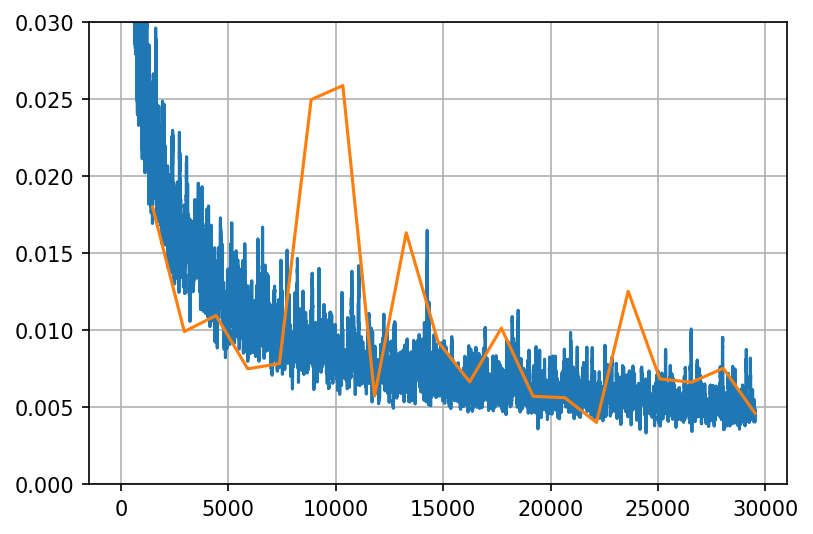

In [12]:
plot_loss_epoch(losses_show, val_losses)

### Testing using n in, 1 out


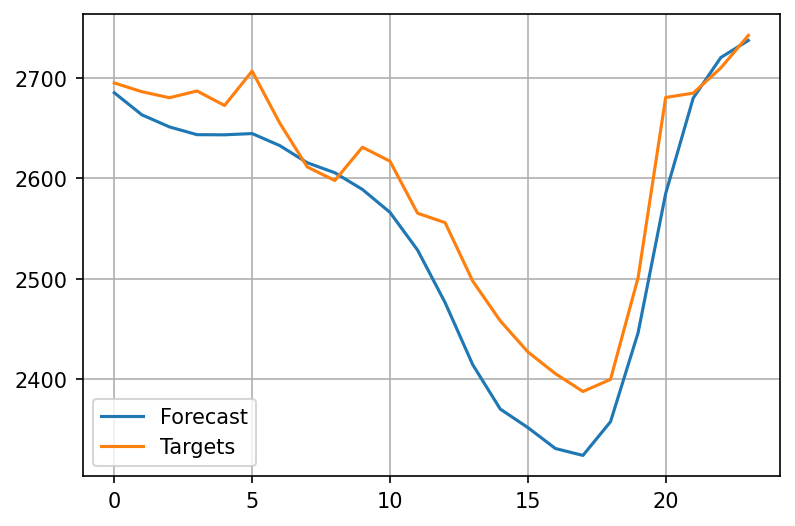

In [14]:
start_point = 1100
fw = 24
tw = 100

historic_data = df_test.copy(deep=True)[start_point : start_point + tw + fw].values
targets = copy.deepcopy(historic_data)[tw : tw + fw][:, 1]

predictions = []

for i in range(fw):
    x = historic_data[i : tw + i].reshape(-1, 2)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    p = model(x)

    predictions.append(p.item())
    historic_data[-fw + i, 1] = p.item()


# denormalize
predictions = (
    np.array(predictions) * train_std["consumption"] + train_mean["consumption"]
)
targets = np.array(targets) * train_std["consumption"] + train_mean["consumption"]

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()